## Loading data and Preprocessing


1.   Used KNN imputation as it improved AUC score than normanl mean, mode imputaion.
2.    One Hot encoded categorical features
3.   Standardized values



In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd drive/My\ Drive/Datasets/Janata_hackathon_04

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Datasets/Janata_hackathon_04


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.impute import KNNImputer
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [4]:
train_df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,23798,city_149,0.689,Male,Has relevent experience,no_enrollment,Graduate,STEM,3,100-500,Pvt Ltd,1,106,0
1,29166,city_83,0.923,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,<10,Funded Startup,1,69,0
2,46,city_16,0.910,NaN,Has relevent experience,no_enrollment,Graduate,STEM,6,50-99,Public Sector,2,4,0
3,18527,city_64,0.666,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,50-99,Pvt Ltd,1,26,0
4,21751,city_100,0.887,NaN,No relevent experience,no_enrollment,Masters,STEM,8,NaN,NaN,2,88,1


In [5]:
train_df.isna().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4098
relevent_experience          0
enrolled_university        342
education_level            457
major_discipline          2838
experience                  59
company_size              4779
company_type              5039
last_new_job               367
training_hours               0
target                       0
dtype: int64

In [6]:
test_df.isna().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    3388
relevent_experience          0
enrolled_university        279
education_level            395
major_discipline          2393
experience                  44
company_size              4051
company_type              4330
last_new_job               304
training_hours               0
dtype: int64

In [7]:
train_df.nunique()

enrollee_id               18359
city                        123
city_development_index       93
gender                        3
relevent_experience           2
enrolled_university           3
education_level               5
major_discipline              6
experience                   22
company_size                  8
company_type                  6
last_new_job                  6
training_hours              241
target                        2
dtype: int64

In [8]:
train_df['target'].value_counts()

0    15934
1     2425
Name: target, dtype: int64

In [0]:
train_size = len(train_df)

In [0]:
Y = train_df['target'].values
ids = test_df['enrollee_id']
train_df = train_df.drop(['target'], axis=1)

In [0]:
df = pd.concat([train_df, test_df],axis=0)
df = df.drop(['enrollee_id'], axis=1)

In [12]:
df.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,city_149,0.689,Male,Has relevent experience,no_enrollment,Graduate,STEM,3,100-500,Pvt Ltd,1,106
1,city_83,0.923,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,<10,Funded Startup,1,69
2,city_16,0.910,NaN,Has relevent experience,no_enrollment,Graduate,STEM,6,50-99,Public Sector,2,4
3,city_64,0.666,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,50-99,Pvt Ltd,1,26
4,city_100,0.887,NaN,No relevent experience,no_enrollment,Masters,STEM,8,NaN,NaN,2,88


In [13]:
df['last_new_job'].value_counts()

1        13813
>4        6023
2         5133
never     3943
3         1922
4         1875
Name: last_new_job, dtype: int64

In [14]:
df['experience'].value_counts()

>20    6150
5      2400
4      2240
3      2166
6      2039
7      1779
2      1756
10     1753
9      1722
8      1423
15     1244
11     1190
14     1080
16      964
12      905
1       818
<1      782
13      763
17      659
19      590
18      533
20      321
Name: experience, dtype: int64

In [0]:
l = []
for i in df['experience']:
  if(i=='>20'):
    l.append(20.0)
  elif(i=='<1'):
    l.append(0.0)
  else:
    l.append(float(i))
df['experience'] = l

In [0]:
cat_col = ['city', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'last_new_job', 'company_size', 'company_type']
con_col = ['city_development_index', 'experience', 'training_hours']
cols = list(df.columns.values)

In [0]:
ce_bin = ce.OneHotEncoder(cols=cat_col)
df = ce_bin.fit_transform(df)

In [0]:
imputer = KNNImputer(n_neighbors=3)
new_df = imputer.fit_transform(df)
tdf = pd.DataFrame()
j = 0 
for i in list(df.columns.values):
  df[i] = new_df[:,j]
  j += 1

In [19]:
df=((df-df.min())/(df.std()))
df.head(3)

,city_1,city_2,city_3,city_4,city_5,city_6,city_7,city_8,city_9,city_10,city_11,city_12,city_13,city_14,city_15,city_16,city_17,city_18,city_19,city_20,city_21,city_22,city_23,city_24,city_25,city_26,city_27,city_28,city_29,city_30,city_31,city_32,city_33,city_34,city_35,city_36,city_37,city_38,city_39,city_40,...,enrolled_university_3,enrolled_university_4,education_level_1,education_level_2,education_level_3,education_level_4,education_level_5,education_level_6,major_discipline_1,major_discipline_2,major_discipline_3,major_discipline_4,major_discipline_5,major_discipline_6,major_discipline_7,experience,company_size_1,company_size_2,company_size_3,company_size_4,company_size_5,company_size_6,company_size_7,company_size_8,company_size_9,company_type_1,company_type_2,company_type_3,company_type_4,company_type_5,company_type_6,company_type_7,last_new_job_1,last_new_job_2,last_new_job_3,last_new_job_4,last_new_job_5,last_new_job_6,last_new_job_7,training_hours
0,13.155323,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.029187,0.0,0.0,0.0,0.0,0.0,2.293115,0.0,0.0,0.0,0.0,0.0,0.0,0.460965,2.83886,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,2.00729,0.000000,0.000000,0.0,0.0,0.0,0.0,2.030363,0.000000,0.0,0.0,0.0,0.0,0.0,1.739460
1,0.000000,11.763054,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.029187,0.0,0.0,0.0,0.0,0.0,2.293115,0.0,0.0,0.0,0.0,0.0,0.0,2.151168,0.00000,3.82444,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,4.337561,0.000000,0.0,0.0,0.0,0.0,2.030363,0.000000,0.0,0.0,0.0,0.0,0.0,1.126507
2,0.000000,0.000000,3.534975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.029187,0.0,0.0,0.0,0.0,0.0,2.293115,0.0,0.0,0.0,0.0,0.0,0.0,0.921929,0.00000,0.00000,2.65797,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,4.436595,0.0,0.0,0.0,0.0,0.000000,2.772094,0.0,0.0,0.0,0.0,0.0,0.049699


In [0]:
train_df = df[:train_size].copy()
test_df = df[train_size:].copy()

In [21]:
test_df.shape

(15021, 172)

# Models
1. Used an ensemble of Xgboost, Catboost, LightGBM and H2O GBT for final modeling.
2. Under Sampling or Over Sampling didn't improve AUC score.

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score as roc
X_train, X_test, y_train, y_test = train_test_split(train_df, Y,test_size=0.2, random_state=0, stratify=Y)
X_train.shape, X_test.shape

((14687, 172), (3672, 172))

In [23]:
from catboost import CatBoostClassifier, Pool
cat = CatBoostClassifier(iterations=200, custom_metric=['AUC'], class_weights=[1,10], logging_level='Silent')
cat.fit(X_train, y_train, eval_set=(X_test,y_test), use_best_model=True)
print(roc(y_test,cat.predict_proba(X_test)[:,1]))

0.6562588350224333


In [24]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_esttimators=500, max_depth=4, scale_pos_weight=10)
xgb.fit(X_train, y_train)
print(roc(y_test,xgb.predict_proba(X_test)[:,1]))

0.6507137565949297


In [25]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(n_estimators=200, max_features=50, class_weight={0:1,1:10})
lgb.fit(X_train, y_train)
print(roc(y_test,lgb.predict_proba(X_test)[:,1]))

0.6319231801875532


In [26]:
lgb.feature_importances_

array([  15,    3,   51,   15,   20,   15,   38,   88,   19,   29,    3,
          8,    7,   22,    0,   29,   17,   10,    9,    0,   21,   10,
          0,    7,   24,    7,    8,    0,   24,    1,    8,    0,   14,
          0,    8,    3,    2,   16,   18,   22,    0,    3,   15,    1,
          0,    0,    4,    0,   12,   17,    0,    4,    9,    8,   11,
          2,   13,    2,    6,   11,   13,    0,    0,   16,   15,    0,
          0,    8,    0,   31,    4,    8,    0,    0,    0,    0,    6,
          0,   11,    0,    0,   13,    0,    0,    0,    0,    8,   12,
          0,    0,    0,    0,    0,    0,    0,    0,   26,    0,    0,
          0,    0,    0,    6,    0,    0,    0,    0,    0,    0,   13,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,  564,  121,   95,   27,   16,   96,    7,   80,   54,
         33,   12,  122,   87,   46,   23,   22,   18,   65,   24,   15,
         43,    8,    8,   10,  832,   53,   33,   

In [27]:
from sklearn.linear_model import LogisticRegression as LR
lr = LR(max_iter=500, class_weight={0:1,1:10})
lr.fit(X_train, y_train)
print(roc(y_test,lr.predict_proba(X_test)[:,1]))

0.6390623635322622


Fold 1 : 
 LR : 0.6354102846939402
LGM : 0.643807478189423
Cat : 0.64435221696389
XGB : 0.6483151592002303


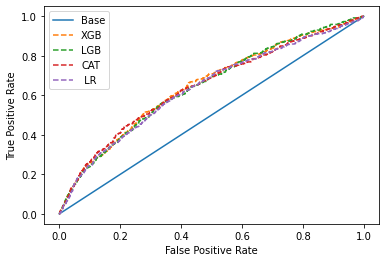

Fold 2 : 
 LR : 0.6448309660055833
LGM : 0.6601612866703974
Cat : 0.6671105877938404
XGB : 0.6659441222233364


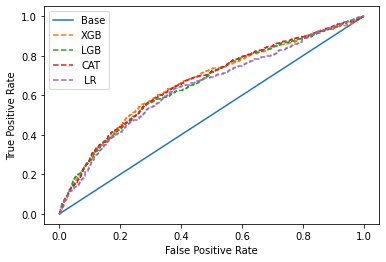

Fold 3 : 
 LR : 0.6605313467404631
LGM : 0.6510336774072505
Cat : 0.6834679545447193
XGB : 0.6865539449891473


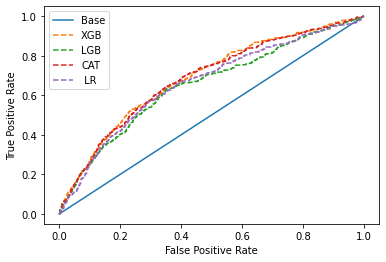

Fold 4 : 
 LR : 0.6620963385402683
LGM : 0.6591355345006616
Cat : 0.6767767897288922
XGB : 0.6726229948340391


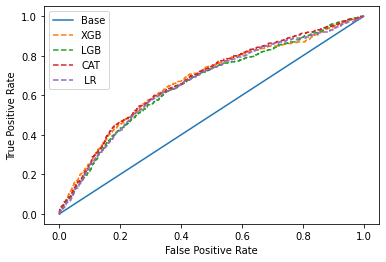

Fold 5 : 
 LR : 0.6191268500721585
LGM : 0.6404385164476025
Cat : 0.6510548728004609
XGB : 0.6425489092097514


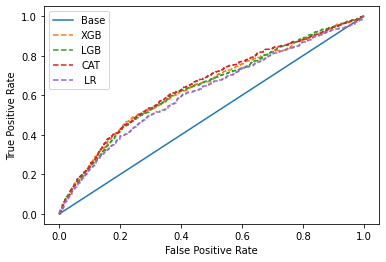

In [28]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
cnt = 0
for train_index, test_index in kfold.split(train_df, Y):
  X_train, X_test = train_df.loc[train_index], train_df.loc[test_index]
  y_train, y_test = Y[train_index], Y[test_index] ;cnt+=1

  print('Fold '+str(cnt)+' : ')

  lr = LR(max_iter=500)
  lr.fit(X_train, y_train)
  print(' LR : ',end='')
  print(roc(y_test,lr.predict_proba(X_test)[:,1]))

  lgb = LGBMClassifier(n_estimators=80)
  lgb.fit(X_train, y_train, eval_metric='AUC',eval_set=(X_train,y_train), early_stopping_rounds=50, verbose=False)
  print('LGM : ',end='')
  print(roc(y_test,lgb.predict_proba(X_test)[:,1]))

  cat = CatBoostClassifier(iterations=1500, logging_level='Silent')
  cat.fit(X_train, y_train, eval_set=(X_test,y_test), use_best_model=True)
  print('Cat : ',end='')
  print(roc(y_test,cat.predict_proba(X_test)[:,1]))

  xgb = XGBClassifier(n_estimators=80)
  xgb.fit(X_train, y_train, eval_metric='auc',eval_set=[(X_train,y_train)], early_stopping_rounds=50, verbose=False)
  print('XGB : ',end='')
  print(roc(y_test,xgb.predict_proba(X_test)[:,1]))

  t_fpr, t_tpr, _ = roc_curve(y_test, [0 for _ in y_test])
  plt.plot(t_fpr, t_tpr, label='Base')

  xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb.predict_proba(X_test)[:,1])
  plt.plot(xgb_fpr, xgb_tpr, linestyle='--', label='XGB')

  lgb_fpr, lgb_tpr, _ = roc_curve(y_test, lgb.predict_proba(X_test)[:,1])
  plt.plot(lgb_fpr, lgb_tpr, linestyle='--', label='LGB')

  cat_fpr, cat_tpr, _ = roc_curve(y_test, cat.predict_proba(X_test)[:,1])
  plt.plot(cat_fpr, cat_tpr, linestyle='--', label='CAT')
  
  lr_fpr, lr_tpr, _ = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
  plt.plot(lr_fpr, lr_tpr, linestyle='--', label=' LR')

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.show()


In [29]:
import h2o
h2o.init()

from h2o.estimators.gbm import H2OGradientBoostingEstimator

new_df = train_df.copy()
new_df['target'] = Y

data_train_h2o=h2o.H2OFrame(new_df)
data_test_h2o=h2o.H2OFrame(test_df)
data_train_h2o['target']=data_train_h2o['target'].asfactor()

model = H2OGradientBoostingEstimator(## more trees is better if the learning rate is small enough 
  ## here, use "more than enough" trees - we have early stopping
  ntrees = 1000,                                                            
  ## smaller learning rate is better (this is a good value for most datasets, but see below for annealing)
  learn_rate = 0.01,                                                         
  ## early stopping once the validation AUC doesn't improve by at least 0.01% for 5 consecutive scoring events
  stopping_rounds = 50, stopping_tolerance = 1e-4, stopping_metric = "AUC", 
  ## sample 80% of rows per tree
  sample_rate = 0.8,                                                       
  ## sample 80% of columns per split
  col_sample_rate = 0.8,                                                   
  ## fix a random number generator seed for reproducibility
  seed = 0,
  ## score every 10 trees to make early stopping reproducible (it depends on the scoring interval)
  score_tree_interval = 10, nfolds=5, max_depth=3)

model.train(x=data_train_h2o.names[:-1],y=data_train_h2o.names[-1], training_frame=data_train_h2o, model_id="GBM_Titanic",validation_frame=data_train_h2o)
print(model.cross_validation_metrics_summary())
f=model.predict(test_data=data_test_h2o)
f=f.as_data_frame()
f.head()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.7" 2020-04-14; OpenJDK Runtime Environment (build 11.0.7+10-post-Ubuntu-2ubuntu218.04); OpenJDK 64-Bit Server VM (build 11.0.7+10-post-Ubuntu-2ubuntu218.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpoqml115_
  JVM stdout: /tmp/tmpoqml115_/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpoqml115_/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.2
H2O_cluster_version_age:,10 days
H2O_cluster_name:,H2O_from_python_unknownUser_dl91nx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.71008086,0.020304246,0.6905866,0.7284822,0.73117125,0.688131,0.7120332
1,auc,0.66301733,0.025109615,0.6370457,0.68949306,0.65814215,0.6416109,0.68879485
2,aucpr,0.24033508,0.016867252,0.21699804,0.25462538,0.23627514,0.23491322,0.25886363
3,err,0.28991914,0.020304246,0.30941337,0.27151778,0.26882872,0.31186903,0.28796682
4,err_count,1064.2,69.79756,1134.0,1000.0,1003.0,1143.0,1041.0
5,f0point5,0.2610326,0.018140024,0.23790564,0.26593408,0.25977013,0.25395584,0.28759736
6,f1,0.32044554,0.022584163,0.29652604,0.32614556,0.3106529,0.3126879,0.3562152
7,f2,0.41520053,0.032358732,0.39348042,0.4216028,0.3863248,0.40675846,0.46783626
8,lift_top_group,2.7276568,0.30253956,2.2938833,3.01638,2.6048872,2.7138097,3.0093236
9,logloss,0.37030476,0.012826842,0.37166205,0.3527401,0.36981907,0.3888539,0.36844867



See the whole table with table.as_data_frame()

gbm prediction progress: |████████████████████████████████████████████████| 100%


,predict,p0,p1
0,1,0.217680,0.782320
1,0,0.920790,0.079210
2,1,0.622055,0.377945
3,0,0.937106,0.062894
4,0,0.930335,0.069665


In [0]:
y_h2o = f['p1']

In [31]:
lgb = LGBMClassifier()
xgb = XGBClassifier()
cat = CatBoostClassifier(logging_level='Silent')

lgb.fit(train_df,Y)
xgb.fit(train_df,Y)
cat.fit(train_df,Y)

In [32]:
cat_pred = cat.predict_proba(test_df)[:,1]
xgb_pred = xgb.predict_proba(test_df)[:,1]
lgb_pred = lgb.predict_proba(test_df)[:,1]
p = 0.3;q=0.18;r=0.3;s=1-p-q-r
y_pred = [ (p*i) + (q*j) + (r*k) + (s*l) for i,j,k,l in zip(xgb_pred,lgb_pred,cat_pred,y_h2o)]
print(len(y_pred))

15021


In [33]:
%cd ..
%cd ..
%cd ..
%cd ..
!ls

/content/drive/My Drive/Datasets
/content/drive/My Drive
/content/drive
/content
catboost_info  drive  sample_data


In [34]:
sub = pd.DataFrame({'enrollee_id':ids,'target':y_pred})
sub.to_csv('subs.csv', index=False)
sub.head()

,enrollee_id,target
0,16548,0.720811
1,12036,0.079449
2,11061,0.380279
3,5032,0.053176
4,17599,0.074295
